# Intoduction

### Key Aspects of Feature Matching
#### 1. Feature Detection
The process begins by detecting key features in each image. These features are typically points of interest that are easy to distinguish, such as corners or edges.
Common feature detectors include Harris Corner Detector, Laplacian of Gaussian for blob detection, and Canny Edge Detector.
#### 2. Feature Description
Once features are detected, they are described using feature descriptors, which provide a numerical representation of the feature's characteristics.
Popular feature descriptors include SIFT (Scale-Invariant Feature Transform), SURF (Speeded Up Robust Features), ORB (Oriented FAST and Rotated BRIEF), and BRIEF (Binary Robust Independent Elementary Features).
#### 3. Feature Matching
The core step involves comparing the feature descriptors from different images to find matches.
Techniques like brute-force matching, where each feature is compared with all features in the other image, and K-Nearest Neighbors (KNN) matching, where the closest matches are identified, are commonly used.
Robust matching methods like RANSAC (Random Sample Consensus) help in dealing with noise and outliers to improve accuracy.

In [39]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image


In [40]:
train_labels = pd.read_csv("/kaggle/input/image-matching-challenge-2025/train_labels.csv")
train_labels.head()

,dataset,scene,image,rotation_matrix,translation_vector
0,imc2023_haiper,fountain,fountain_image_116.png,0.122655949;0.947713775;-0.294608417;0.1226706...,0.093771314;-0.803560988;2.062001533
1,imc2023_haiper,fountain,fountain_image_108.png,0.474305910;0.359108654;-0.803787832;0.2888416...,0.358946647;-0.797557548;1.910906929
2,imc2023_haiper,fountain,fountain_image_101.png,0.565115476;-0.138485064;-0.813305838;0.506678...,0.146922468;-0.981392596;2.009002852
3,imc2023_haiper,fountain,fountain_image_082.png,-0.308320392;-0.794654112;0.522937261;0.948141...,0.206413831;-1.174321103;3.667167680
4,imc2023_haiper,fountain,fountain_image_071.png,-0.569002830;-0.103808175;0.815757098;0.778745...,-0.015140892;-1.334052012;3.488936597


In [41]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   dataset             1945 non-null   object
 1   scene               1945 non-null   object
 2   image               1945 non-null   object
 3   rotation_matrix     1945 non-null   object
 4   translation_vector  1945 non-null   object
dtypes: object(5)
memory usage: 76.1+ KB


In [42]:
scene_number =train_labels["scene"].unique()
scecne_count=train_labels["scene"].value_counts()

scene_number,scecne_count

(array(['fountain', 'bike', 'chairs', 'outliers', 'dioscuri', 'cyprus',
        'wall', 'church', 'kyiv-puppet-theater', 'baalshamin', 'lizard',
        'pond', 'british_museum', 'buckingham_palace', 'brandenburg_gate',
        'piazza_san_marco', 'grand_place_brussels', 'trevi_fountain',
        'sacre_coeur', 'taj_mahal', 'st_pauls_cathedral',
        'st_peters_square', 'peach', 'vineyard_split_2',
        'vineyard_split_3', 'vineyard_split_1', 'ET', 'another_ET',
        'stairs_split_1', 'stairs_split_2'], dtype=object),
 scene
 peach                   200
 dioscuri                140
 outliers                122
 st_peters_square        100
 grand_place_brussels    100
 st_pauls_cathedral      100
 lizard                   90
 pond                     90
 vineyard_split_3         85
 trevi_fountain           75
 brandenburg_gate         75
 taj_mahal                75
 british_museum           75
 buckingham_palace        75
 sacre_coeur              75
 piazza_san_marco        

In [43]:
dataset_counts = train_labels["dataset"].value_counts()
num_datasets = train_labels["dataset"].nunique()
num_datasets,dataset_counts

(13,
 dataset
 pt_brandenburg_british_buckingham    225
 pt_sacrecoeur_trevi_tajmahal         225
 imc2024_lizard_pond                  214
 imc2023_heritage                     209
 pt_stpeters_stpauls                  200
 amy_gardens                          200
 pt_piazzasanmarco_grandplace         168
 fbk_vineyard                         163
 imc2024_dioscuri_baalshamin          138
 imc2023_theather_imc2024_church       76
 imc2023_haiper                        54
 stairs                                51
 ETs                                   22
 Name: count, dtype: int64)

In [44]:
train_thresholds_path = "../input/image-matching-challenge-2025/train_thresholds.csv"
train_thresholds = pd.read_csv(train_thresholds_path)
train_thresholds.head()

,dataset,scene,thresholds
0,amy_gardens,peach,0.01;0.02;0.05;0.1;0.25;0.5
1,ETs,ET,0.002;0.005;0.008;0.01;0.02;0.04
2,ETs,another_ET,0.002;0.005;0.008;0.01;0.02;0.04
3,fbk_vineyard,vineyard_split_1,0.01;0.02;0.05;0.1;0.25;0.5
4,fbk_vineyard,vineyard_split_2,0.01;0.02;0.05;0.1;0.25;0.5


In [53]:
train_thresholds.describe()


,dataset,scene,thresholds
count,30,30,30
unique,13,29,5
top,fbk_vineyard,dioscuri,0.05;0.1;0.2;0.5;1.0;2.0
freq,3,2,10


 convert the threshold into a list of list, then flatten it 

In [54]:
threshold_lists = train_thresholds["thresholds"].apply(lambda x: list(map(float, x.split(";"))))
all_thresholds = np.concatenate(threshold_lists.values)
all_thresholds

array([1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01, 2.5e-01, 5.0e-01, 2.0e-03,
       5.0e-03, 8.0e-03, 1.0e-02, 2.0e-02, 4.0e-02, 2.0e-03, 5.0e-03,
       8.0e-03, 1.0e-02, 2.0e-02, 4.0e-02, 1.0e-02, 2.0e-02, 5.0e-02,
       1.0e-01, 2.5e-01, 5.0e-01, 1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01,
       2.5e-01, 5.0e-01, 1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01, 2.5e-01,
       5.0e-01, 1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01, 2.5e-01, 5.0e-01,
       1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01, 2.5e-01, 5.0e-01, 0.0e+00,
       0.0e+00, 1.0e-03, 2.5e-02, 5.0e-02, 1.0e-01, 0.0e+00, 0.0e+00,
       1.0e-03, 2.5e-02, 5.0e-02, 1.0e-01, 0.0e+00, 0.0e+00, 1.0e-03,
       2.5e-02, 5.0e-02, 1.0e-01, 2.5e-02, 5.0e-02, 1.0e-01, 2.0e-01,
       5.0e-01, 1.0e+00, 2.5e-02, 5.0e-02, 1.0e-01, 2.0e-01, 5.0e-01,
       1.0e+00, 2.5e-02, 5.0e-02, 1.0e-01, 2.0e-01, 5.0e-01, 1.0e+00,
       2.5e-02, 5.0e-02, 1.0e-01, 2.0e-01, 5.0e-01, 1.0e+00, 2.5e-02,
       5.0e-02, 1.0e-01, 2.0e-01, 5.0e-01, 1.0e+00, 2.5e-02, 5.0e-02,
       1.0e-01, 2.0e

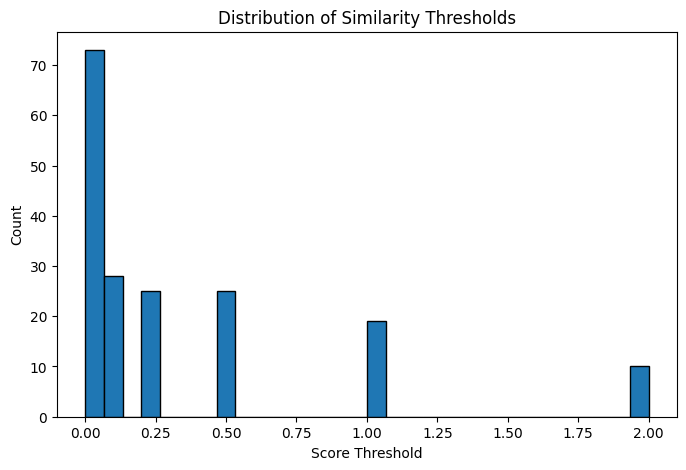

In [55]:
plt.figure(figsize=(8, 5))
plt.hist(all_thresholds, bins=30, edgecolor="black")
plt.xlabel("Score Threshold")
plt.ylabel("Count")
plt.title("Distribution of Similarity Thresholds")
plt.show()

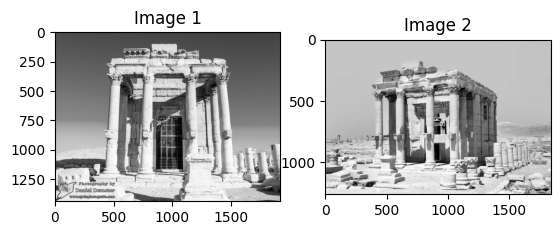

In [56]:
img1 = cv2.imread("/kaggle/input/image-matching-challenge-2025/train/imc2024_dioscuri_baalshamin/baalshamin_19577300988_4e4ff423a7_o.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("/kaggle/input/image-matching-challenge-2025/train/imc2024_dioscuri_baalshamin/baalshamin_194d.png", cv2.IMREAD_GRAYSCALE)

plt.subplot(121), plt.imshow(img1, cmap='gray'), plt.title("Image 1")
plt.subplot(122), plt.imshow(img2, cmap='gray'), plt.title("Image 2")
plt.show()


# Feature Detection 

Like we said before @ the introduction First step is to detect we can use 

1-ORB (fast, binary).

2-SIFT (scale/rotation robust).

3-SURF .

## 1- ORB

ORB uses FAST (Features from Accelerated Segment Test) as its detector.

- How FAST works:

For a candidate pixel, look at a circle of 16 pixels around it.

Compare the center pixel intensity with these 16 neighbors.

If enough neighbors are all brighter or all darker → that pixel is a corner (keypoint).

- ORB improves FAST by:

Using Harris Corner measure to keep only the strongest points.

Adding an orientation (by computing intensity centroid) → makes features rotation-invariant.

- ORB detector = FAST corners + orientation + Harris ranking.

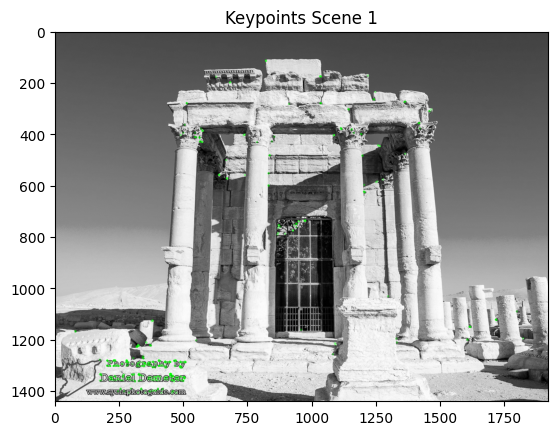

In [57]:
orb = cv2.ORB_create()

# Detect keypoints
kp1_ORB = orb.detect(img1, None)
kp2_ORB = orb.detect(img2, None)

img_kp1 = cv2.drawKeypoints(img1, kp1_ORB, None, color=(0,255,0))
plt.imshow(img_kp1)
plt.title("Keypoints Scene 1")
plt.show()


## 2- SIFT

SIFT finds blobs/extrema in scale space.

- How it works:

Build a Gaussian pyramid (blur images with different σ).

Compute Difference of Gaussians (DoG) between pyramid levels.

Look for local extrema in 3D (x, y, scale).

Keypoints = maxima/minima that are stable across scales.

After detecting, SIFT assigns a dominant orientation to each keypoint (so it’s rotation invariant).

SIFT detector = DoG extrema in scale space.
### Descriptor:

Around each keypoint, SIFT builds a histogram of gradient orientations in local patches (usually 16×16).

Divided into 4×4 cells → each with 8-bin orientation histograms → results in 128-dimensional float descriptor.

These descriptors are robust to scale, rotation, and illumination changes.

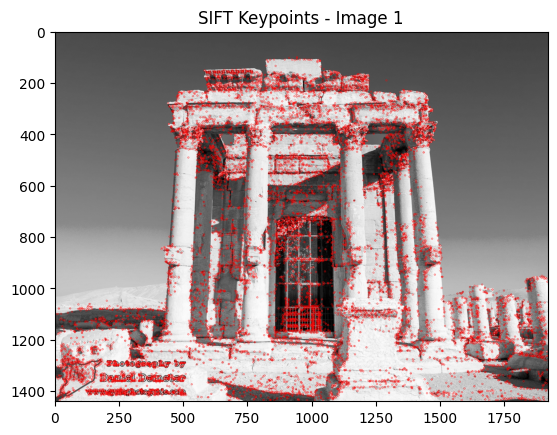

In [58]:
# SIFT Detector
sift = cv2.SIFT_create()

# Detect keypoints + descriptors directly
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Draw keypoints
img_kp1 = cv2.drawKeypoints(img1, kp1, None, color=(255,0,0))
plt.imshow(img_kp1)
plt.title("SIFT Keypoints - Image 1")
plt.show()

# Feature Description

## 1- ORB

ORB uses BRIEF (Binary Robust Independent Elementary Features) as its descriptor.

After finding a keypoint (position + scale + orientation), ORB:

Rotates the patch around the keypoint to a canonical orientation (so it’s rotation-invariant).

Runs BRIEF: it takes random pairs of pixels in the patch and checks which one is brighter.

Each comparison outputs a single bit (0 or 1).

Concatenating many such comparisons gives a binary string (e.g., 256 bits).

In [59]:
# calculate key points like (size and rotation) and Descriptors, which is numpy array, each row describes 1 kp
kp1_ORB, des1_ORB = orb.compute(img1, kp1_ORB)
kp2_ORB, des2_ORB = orb.compute(img2, kp2_ORB)


# Feature Matching

## 1- Brute force 

### ORB

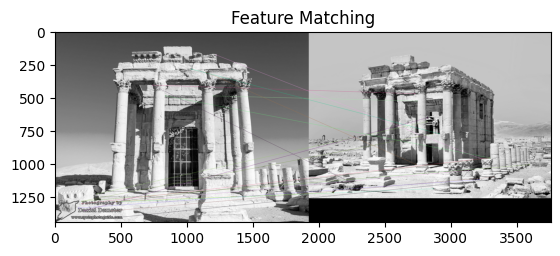

In [60]:
# Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1_ORB, des2_ORB)

# Sort by distance (good → bad)
matches = sorted(matches, key=lambda x:x.distance)

# Draw top matches
img_matches = cv2.drawMatches(img1, kp1_ORB, img2, kp2_ORB, matches[:20], None, flags=2)
plt.imshow(img_matches)
plt.title("Feature Matching")
plt.show()


### SIFT

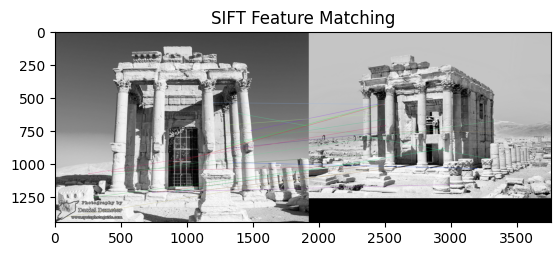

In [61]:
# Brute Force Matcher for SIFT
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort by distance (good → bad)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=2)
plt.imshow(img_matches)
plt.title("SIFT Feature Matching")
plt.show()


## 2- FLANN

### SIFT

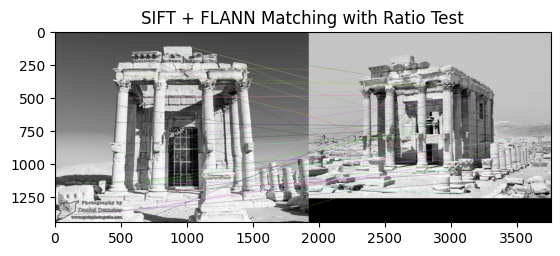

In [62]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1  
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # higher = more accurate but slower

flann = cv2.FlannBasedMatcher(index_params, search_params)

# KNN Match (k=2 → best 2 matches for each descriptor)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe’s ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:  # 0.7 is the common threshold
        good_matches.append(m)

# Draw matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
plt.imshow(img_matches)
plt.title("SIFT + FLANN Matching with Ratio Test")
plt.show()


### ORB

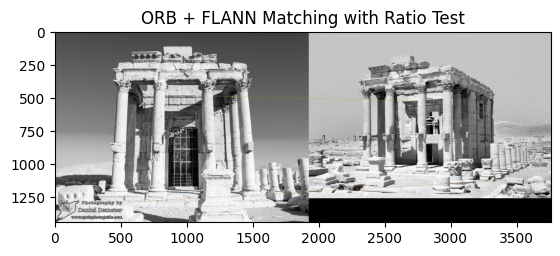

In [66]:
des1_ORB = np.float32(des1_ORB)
des2_ORB = np.float32(des2_ORB)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# KNN Match (k=2 → best 2 matches for each descriptor)
matches = flann.knnMatch(des1_ORB, des2_ORB, k=2)

# Lowe’s ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:  # 0.7 is the common threshold
        good_matches.append(m)

# Draw matches
img_matches = cv2.drawMatches(img1, kp1_ORB, img2, kp2_ORB, good_matches, None, flags=2)
plt.imshow(img_matches)
plt.title("ORB + FLANN Matching with Ratio Test")
plt.show()
